In [1]:
pretty = True
highres = True

%matplotlib inline
if highres:
    %config InlineBackend.figure_format = 'retina'
else:
    %config InlineBackend.figure_format = 'png'

#rcParams["figure.dpi"]=300

import sys
from pathlib import Path

pypsapath = "C:/dev/py/PyPSA/"

if sys.path[0] != pypsapath:
    sys.path.insert(0,pypsapath)

if Path("../..") not in [Path(p) for p in sys.path]:
    sys.path.insert(0,"../..")

%load_ext autoreload
%autoreload 2

In [59]:
import src.globals
from src.scigridnetwork import SciGRID_network
from src.armafitloader import ARMAfit_loader
import src.plothelper

In [3]:
import pypsa
import numpy as np
import pandas as pd
import os
import itertools

import matplotlib.pyplot as plt
import matplotlib.ticker
import matplotlib.dates
import matplotlib.font_manager
from matplotlib import rcParams

rcParams["font.family"] = "sans-serif"


from IPython.display import Markdown, display
printm = lambda s: display(Markdown(s))

In [4]:
sgn = SciGRID_network()

Importing PyPSA from older version of PyPSA than current version 0.13.2.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.



0.13.2 ['C:/dev/py/PyPSA\\pypsa']


In [136]:
#network.generators_t.p_max_pu.describe()
gen_capacity = sgn.network.generators.p_nom[sgn.network.generators_t.p_max_pu.columns]

carriers = sgn.network.generators.carrier.unique()

saturation_per_gen = pd.DataFrame((sgn.network.generators_t.p_max_pu > .95).sum()/len(sgn.network.generators_t.p_max_pu), columns=['saturation'])
saturation_per_gen['source'] = sgn.network.generators.source[saturation_per_gen.index]

saturation_per_gen.groupby('source').mean()

,saturation
source,
Solar,0.000113
Wind Offshore,0.344612
Wind Onshore,0.023988


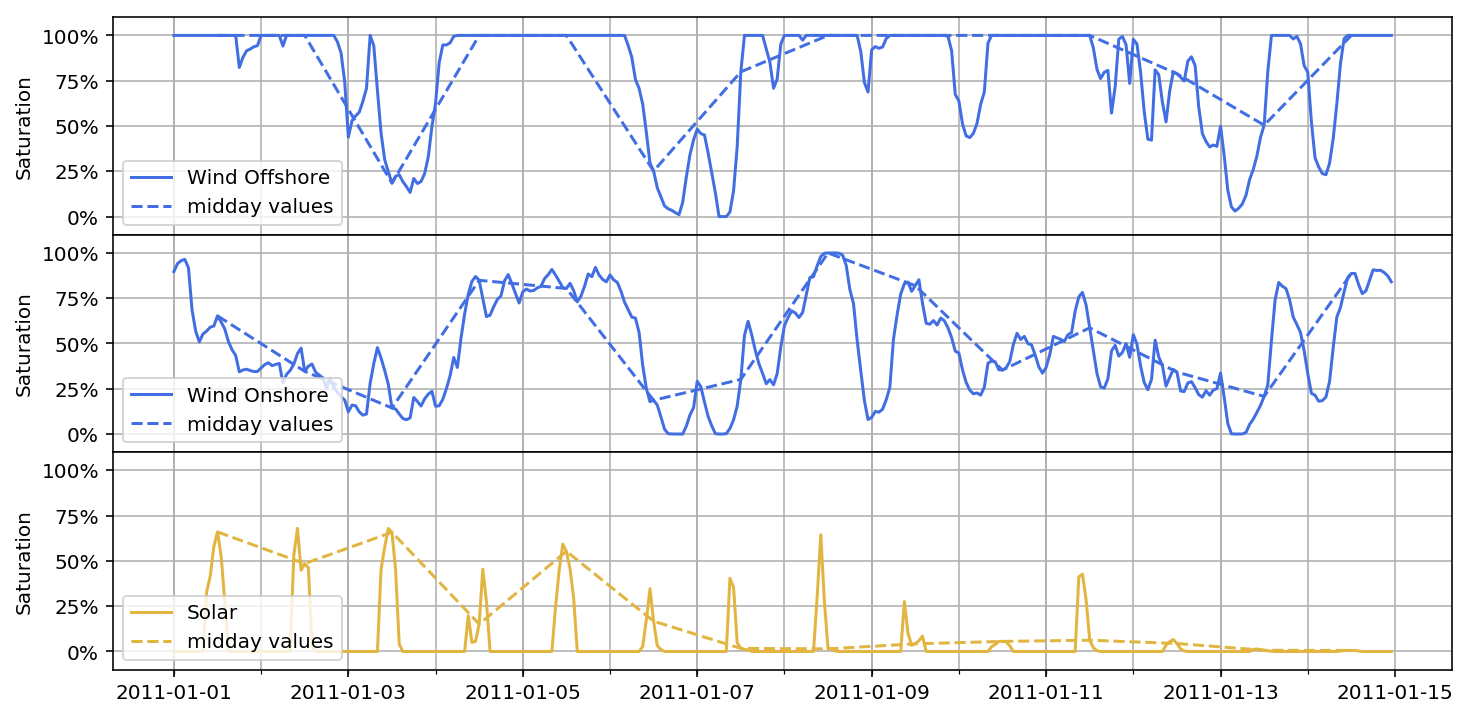

In [133]:
fig, ax = plt.subplots(3,1,figsize=(12,6), sharex=True)
fig.subplots_adjust(hspace=0.0)


gen218 = sgn.network.generators_t.p_max_pu[[s for s in sgn.network.generators_t.p_max_pu.columns if ("270" in s)]]


for i, (source, series) in enumerate(gen218.iteritems()):
    #ax[i].set_title(source[4:])
    c = src.plothelper.solar_color if "Solar" in source else src.plothelper.wind_color
    startday = 0 # 181
    ax[i].plot(series.iloc[startday*24:startday*24+24*14], color=c, label=source[4:])
    ax[i].plot(series.iloc[startday*24 + 12:startday*24+24*14:24], "--", color=c, label="midday values")
    ax[i].legend(loc="lower left")
    ax[i].grid(which="both")
    ax[i].set_ylim(-0.1,1.1)
    ax[i].yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(True))
    ax[i].set_xticks(list(series.index[startday*24:startday*24+24*14:24]), minor=True)
    ax[i].set_ylabel("Saturation")
#[s[4:] for s in gen218.columns]
#list(gen218.iteritems())

plt.savefig(src.globals.git_path/"doc"/"thesis"/"img"/"genseries270jan.pdf", bbox_inches="tight")

In [127]:
print(sgn.network.buses.loc["270"].osm_name)
print(sgn.old_index_to_new[270])


Emden-Borßum
228


DatetimeIndex(['2011-01-01 00:00:00', '2011-01-01 01:00:00',
               '2011-01-01 02:00:00', '2011-01-01 03:00:00',
               '2011-01-01 04:00:00', '2011-01-01 05:00:00',
               '2011-01-01 06:00:00', '2011-01-01 07:00:00',
               '2011-01-01 08:00:00', '2011-01-01 09:00:00',
               '2011-01-01 10:00:00', '2011-01-01 11:00:00',
               '2011-01-01 12:00:00', '2011-01-01 13:00:00',
               '2011-01-01 14:00:00', '2011-01-01 15:00:00',
               '2011-01-01 16:00:00', '2011-01-01 17:00:00',
               '2011-01-01 18:00:00', '2011-01-01 19:00:00',
               '2011-01-01 20:00:00', '2011-01-01 21:00:00',
               '2011-01-01 22:00:00', '2011-01-01 23:00:00'],
              dtype='datetime64[ns]', name='name', freq=None)

In [149]:
offshore_saturation = sgn.network.generators_t.p_max_pu.loc[:,saturation_per_gen.source == 'Solar']

fig = plt.figure(figsize=(12,12))

sats = []

for i,(x,y) in enumerate(offshore_saturation.iteritems()):
    #plt.subplot(3,2,i+1)
    #plt.hist(y,bins=200)
    #plt.title("{}: {:.0%} saturated".format(x,(y > .95).sum()/len(y)))
    sats.append((y > .95).sum()/len(y))

np.max(sats)

0.004452054794520548

<Figure size 864x864 with 0 Axes>

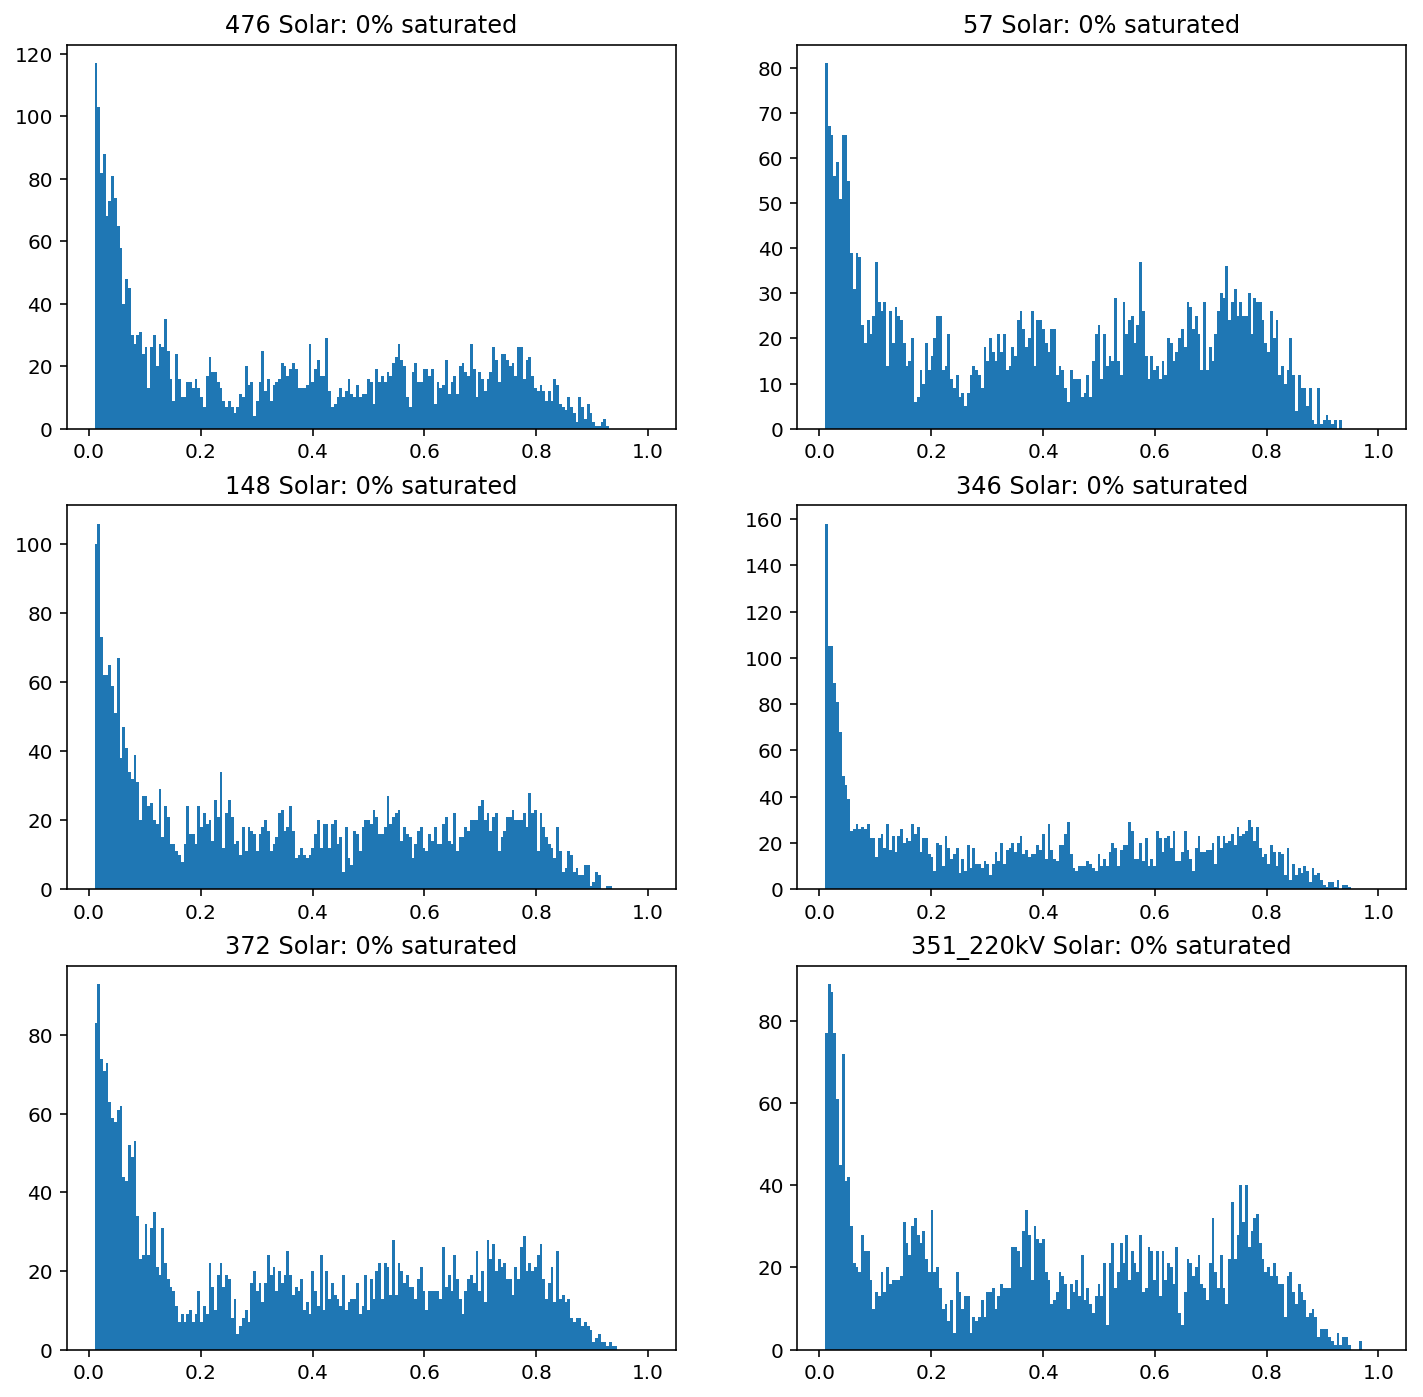

In [13]:
solar_saturation = sgn.network.generators_t.p_max_pu.loc[:,saturation_per_gen.source == 'Solar']

fig = plt.figure(figsize=(12,12))

solar_selection = np.random.choice(solar_saturation.columns, size=6)

for i,(x,y) in enumerate(solar_saturation[solar_selection].iteritems()):
    plt.subplot(3,2,i+1)
    plt.hist(y,bins=np.linspace(0.01,1,num=200))
    plt.title("{0}: {1:.0%} saturated".format(x,(y > .99).sum()/len(y)))

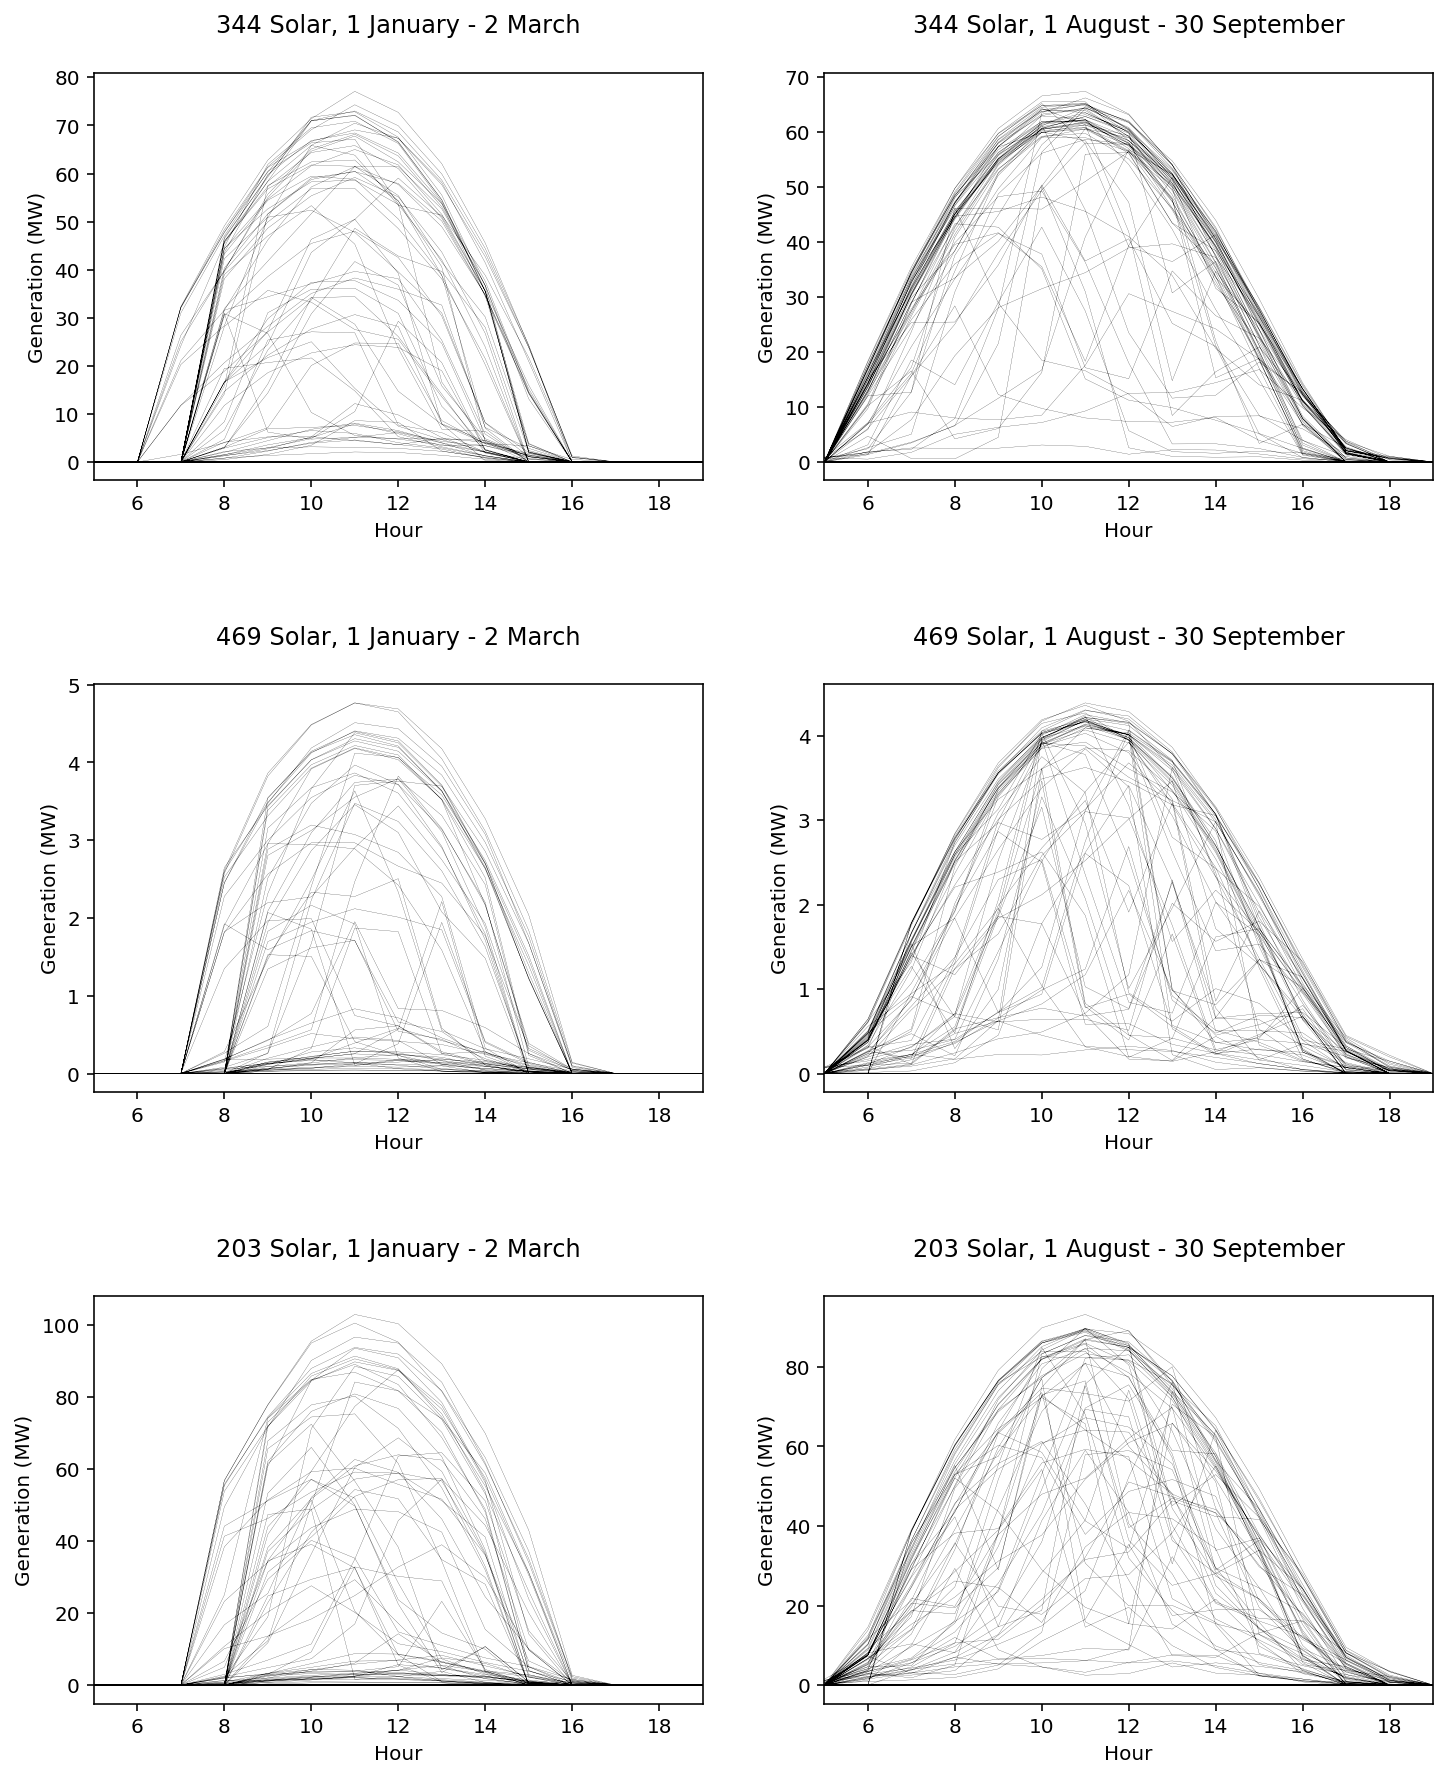

In [16]:
polar_proj = False

solar_generation = sgn.network.generators_t.p_max_pu.loc[:,saturation_per_gen.source == 'Solar'] * gen_capacity.loc[saturation_per_gen.source == 'Solar']

fig = plt.figure(figsize=(12,15))

solar_selection = np.random.choice(solar_generation.columns, size=3)

for i,(gen_name,first_day) in enumerate(itertools.product(solar_selection,[0, (2+7*30)*24])):
    if polar_proj:
        ax = plt.subplot(3,2,i+1,projection='polar')
    else:
        ax = plt.subplot(3,2,i+1)
    #ax = plt.subplot(1,1,1, projection='polar')
    
    gen_series = solar_generation[gen_name]
    #print(x.index.hour)
    x = gen_series.index.hour
    y = gen_series.values
    if polar_proj:
        x *= 2 * np.pi / 24
    
    last_day = first_day + 2*30*24
    
    plt.plot(x[first_day:last_day], y[first_day:last_day], linewidth=.1, c='0')
    if polar_proj:
        ax.set_xticklabels(list(range(0,24,3)))
    else:
        plt.xlim(5,19)
    
    fdate = lambda d: str(d.day) + " " + d.month_name()
    plt.title("{0}, {1} - {2}".format(gen_name, fdate(gen_series.index[first_day]), fdate(gen_series.index[last_day])), pad=20)
    plt.xlabel("Hour")
    if not polar_proj:
        plt.ylabel("Generation (MW)")

fig.subplots_adjust(hspace=.5)

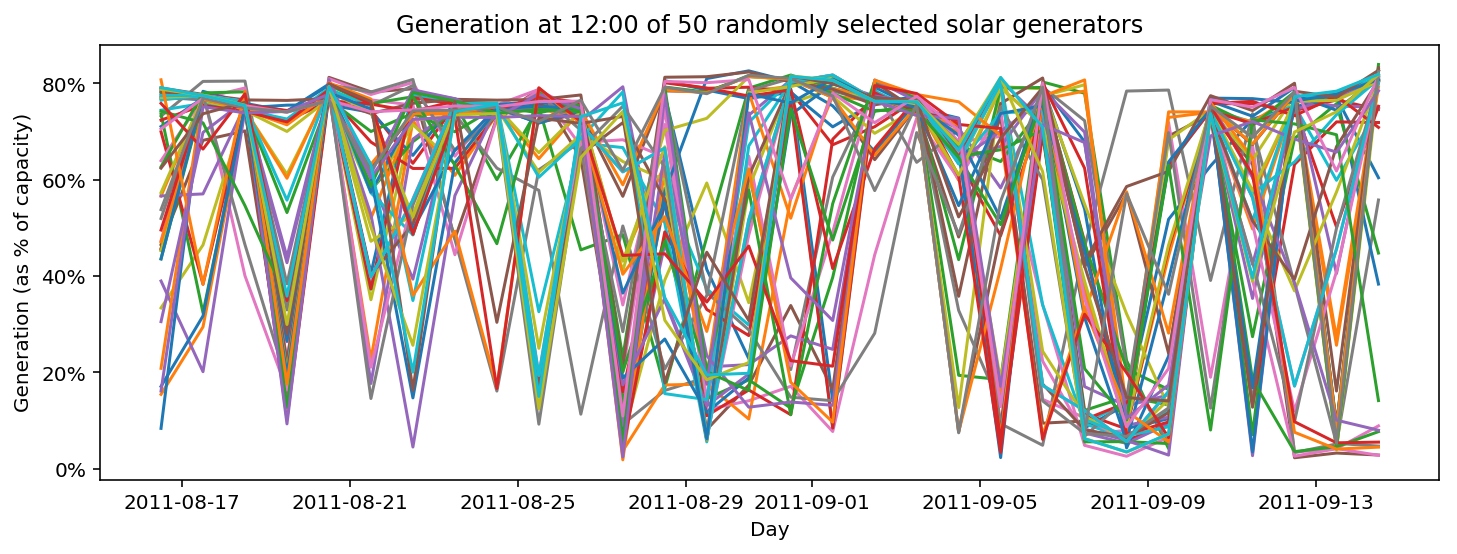

In [11]:
solar_saturation = network.generators_t.p_max_pu.loc[:,saturation_per_gen.carrier == 'Solar']

fig, ax = plt.subplots(figsize=(12,4))

n_generators = 50

hour = 12
d_start = 2+8*30-15
d_end = d_start+30

times = solar_saturation.index[[12+24*i for i in range(d_start, d_end)]]

plt.title(f"Generation at {hour}:00 of {n_generators} randomly selected solar generators")

n_generators = 50
solar_selection = np.random.choice(solar_saturation.columns, size=n_generators, replace=False)
selected_saturation = solar_saturation[solar_selection].loc[times,:]
for gen_name in selected_saturation:
    plt.plot(times, selected_saturation[gen_name])

plt.xlabel("Day")
plt.ylabel("Generation (as % of capacity)")
ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda z, _: '{:.0%}'.format(z)))


## Geographic correlation
Instead of selecting solar generators randomly, let's select all solar generators within a close proximity. We can use a randomly selected generator as a circle centre, and select all generators within a fixed radius.

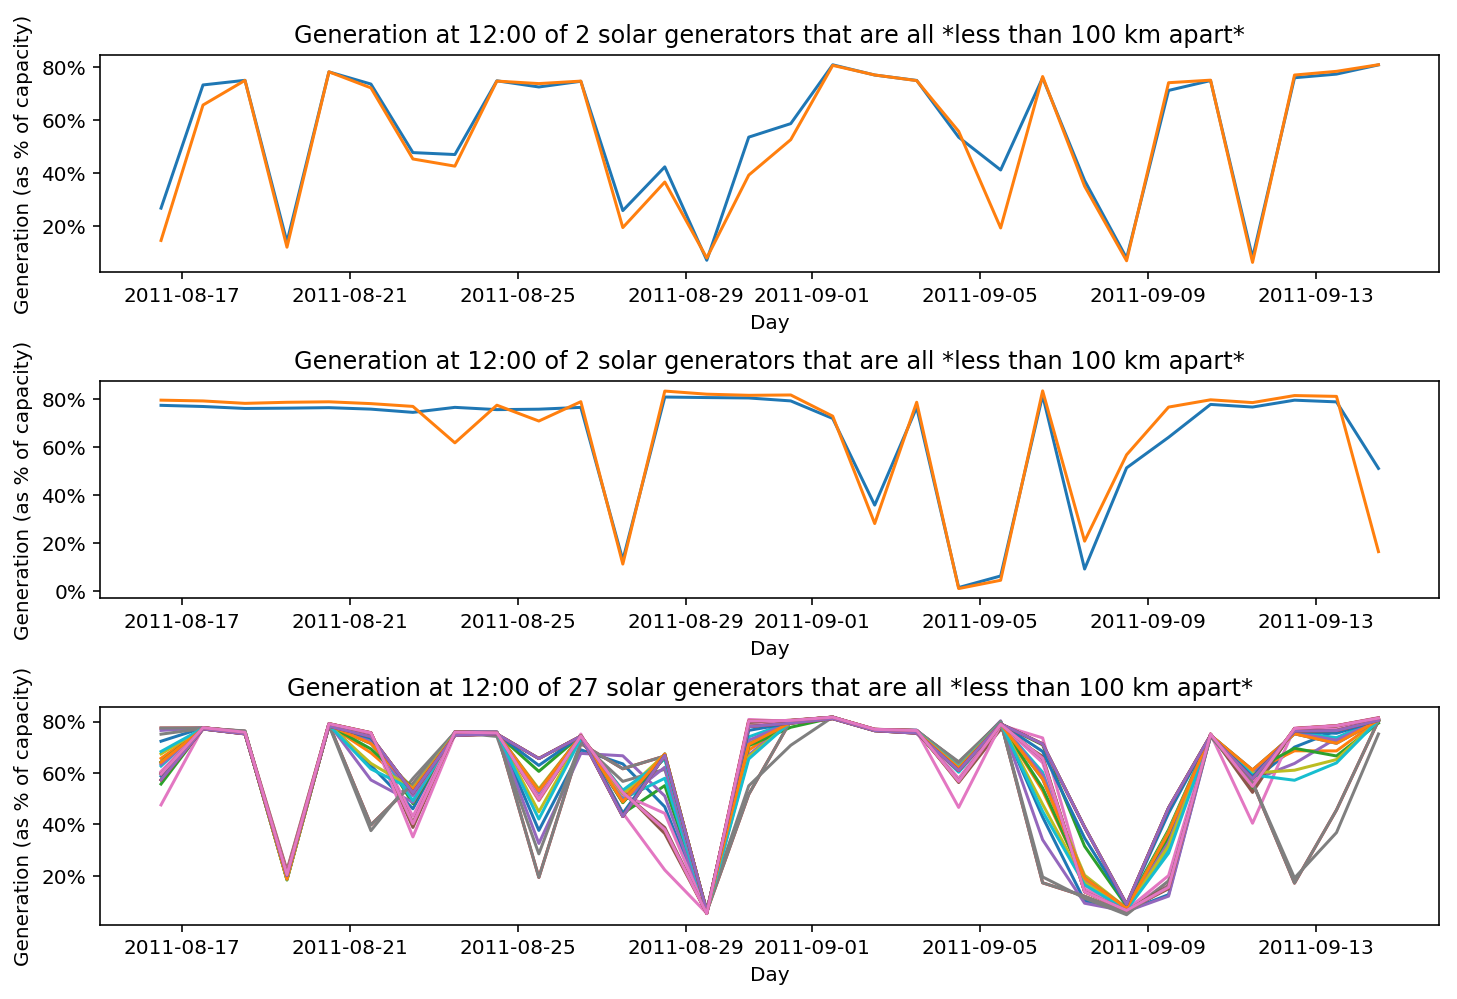

In [12]:
solar_bus_names = network.generators.bus[solar_saturation.columns]
solar_locations = pd.DataFrame(data=network.buses.loc[solar_bus_names.values,:].loc[:,['x','y']].values,index=solar_saturation.columns, columns=['x','y'])

s = lambda z: z*z
dist = lambda a,b: (s(solar_locations.x[a] - solar_locations.x[b])+s(solar_locations.y[a] - solar_locations.y[b]))


dist_lim_km = 50
dist_lim_degree_squared = s(dist_lim_km * np.cos(50 * np.pi / 180) * 360/40000)



fig = plt.figure(figsize=(12,8))

for i in range(3):
    ax = plt.subplot(3,1,i+1)
    
    first_gen = np.random.choice(solar_saturation.columns)
    solar_selection = solar_saturation.loc[:,[dist(a,first_gen) < dist_lim_degree_squared for a in solar_saturation.columns]].columns
    selected_saturation = solar_saturation[solar_selection].loc[times,:]
    
    for gen_name in selected_saturation:
        plt.plot(times, selected_saturation[gen_name])

    plt.title(f"Generation at {hour}:00 of {len(solar_selection)} solar generators that are all *less than {dist_lim_km*2} km apart*")
    plt.xlabel("Day")
    plt.ylabel("Generation (as % of capacity)")
    ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda z, _: '{:.0%}'.format(z)))

fig.subplots_adjust(hspace=.5)